In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('/Users/QUAN/Documents/Machine Learning/salesData.csv')
test = pd.read_csv('/Users/QUAN/Documents/Machine Learning/sales_test.csv')
items = pd.read_csv('/Users/QUAN/Documents/Machine Learning/items.csv')

/Users/QUAN/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 25.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/Users/QUAN/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/Users/QUAN/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 33.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


TypeError: no numeric data to plot

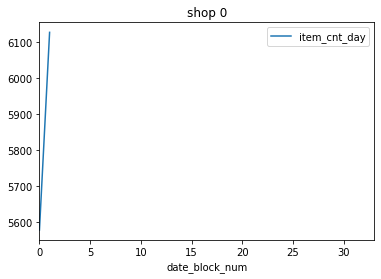

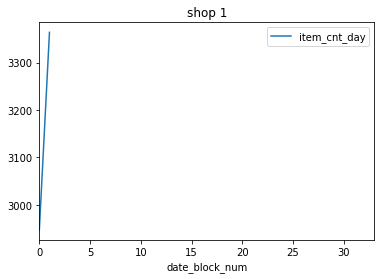

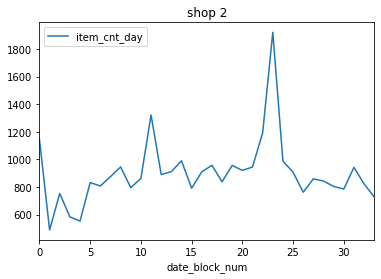

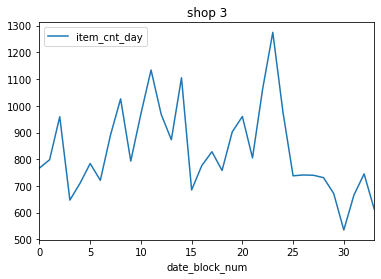

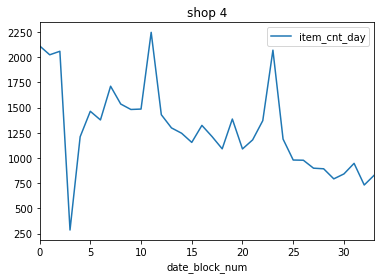

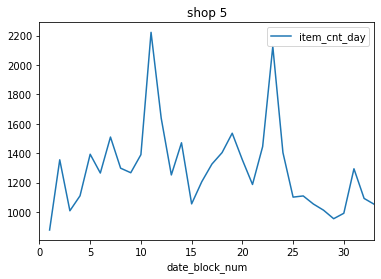

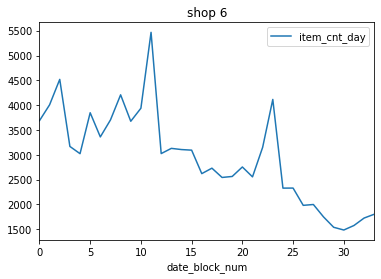

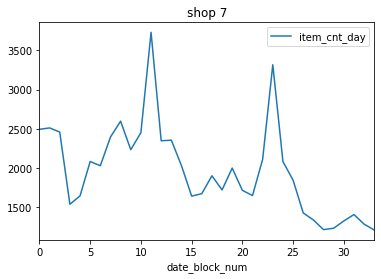

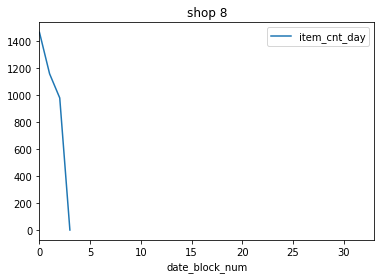

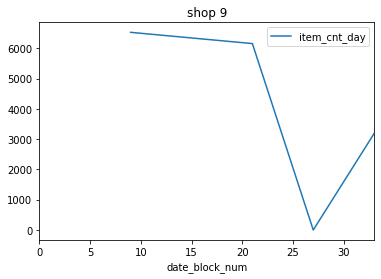

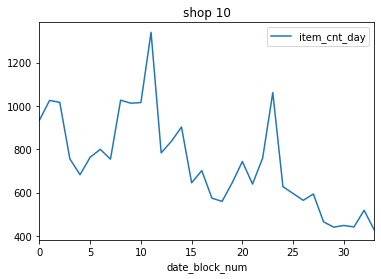

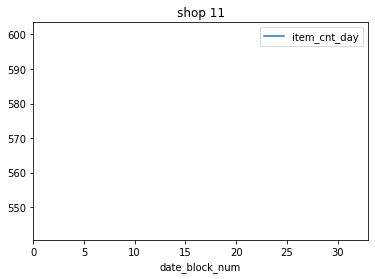

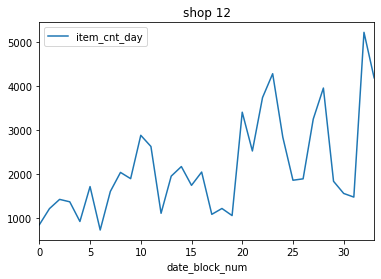

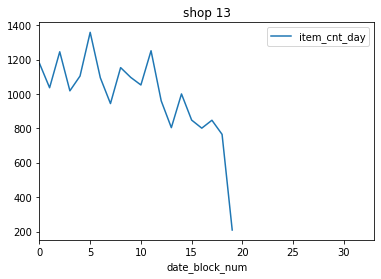

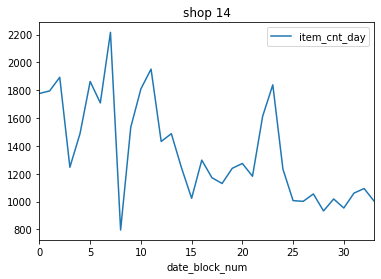

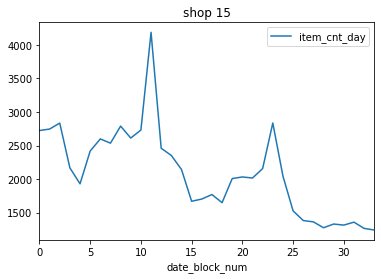

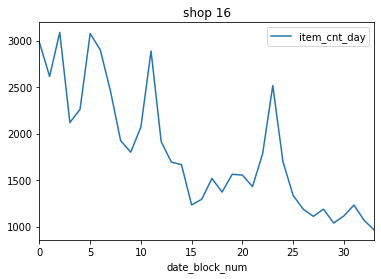

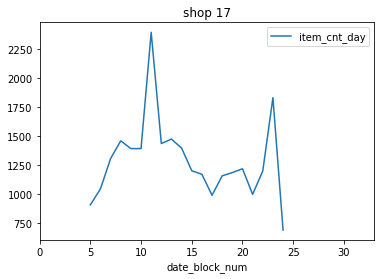

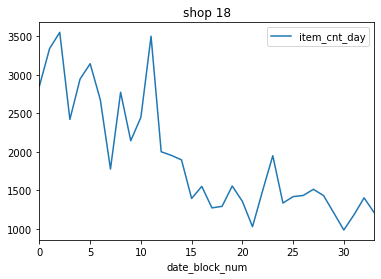

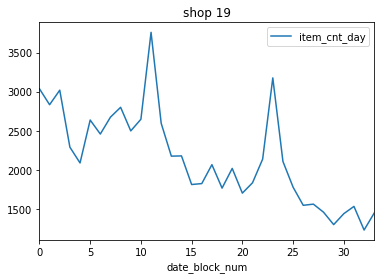

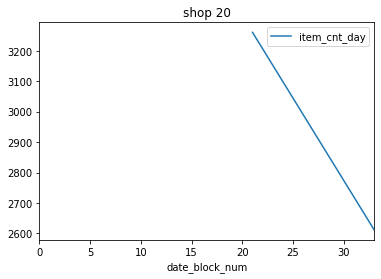

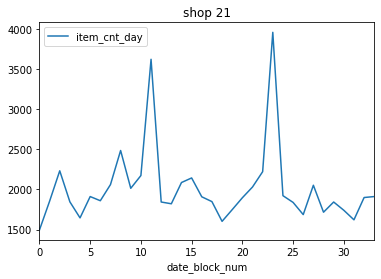

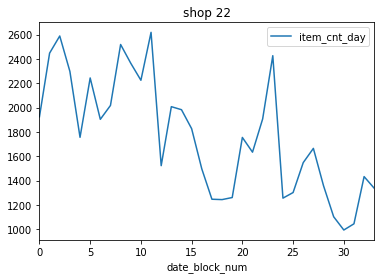

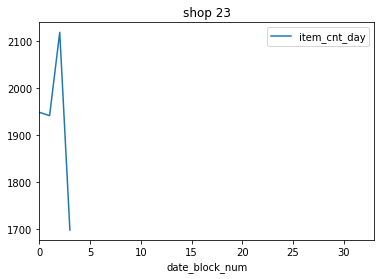

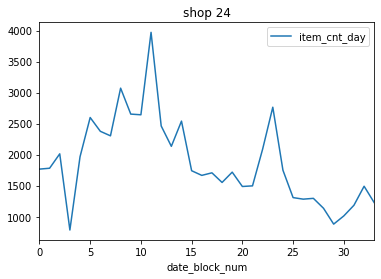

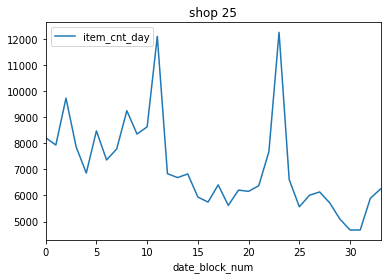

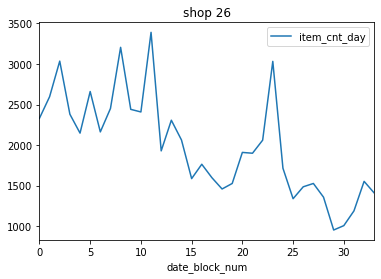

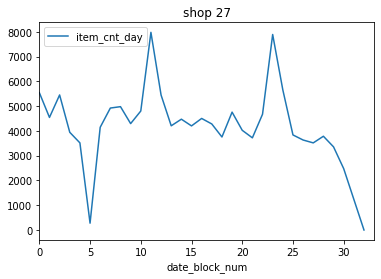

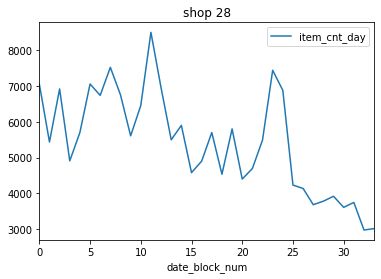

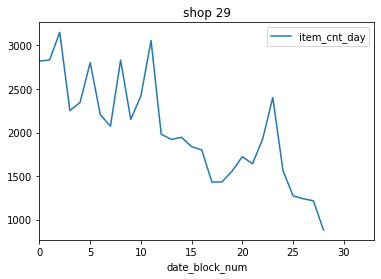

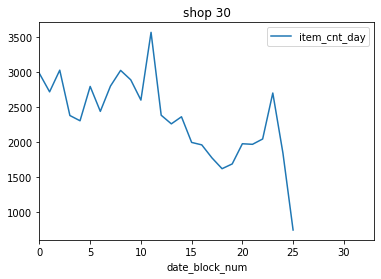

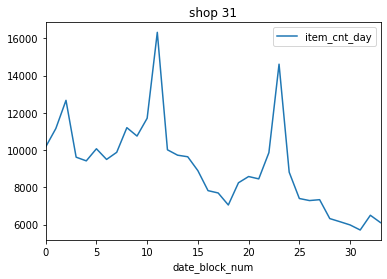

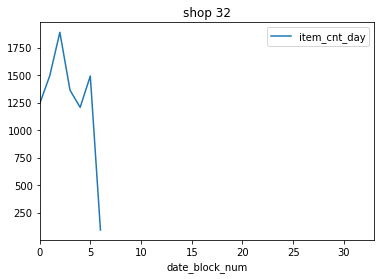

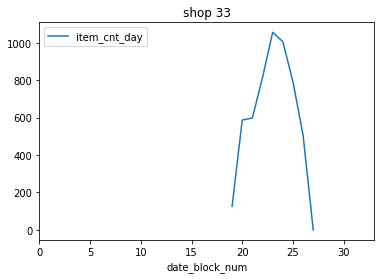

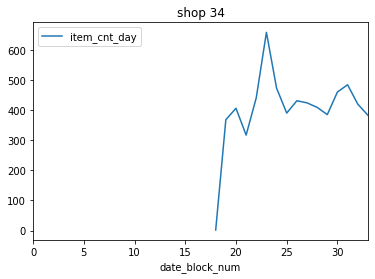

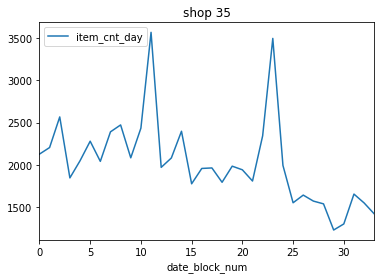

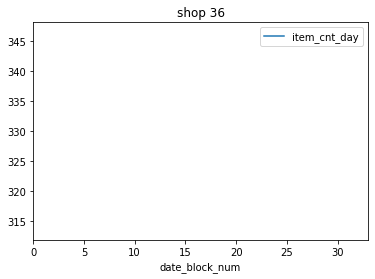

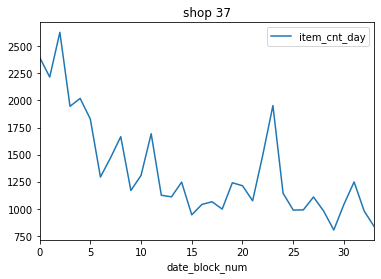

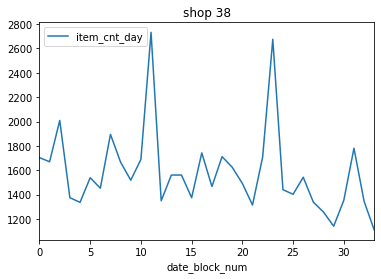

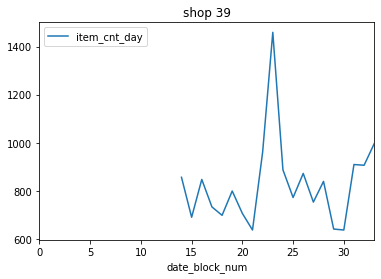

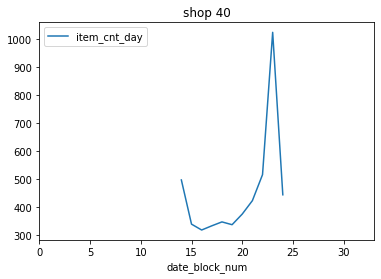

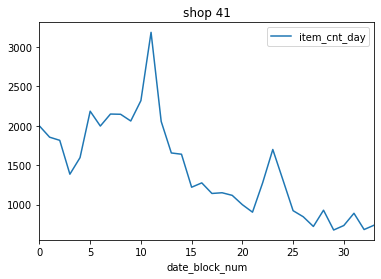

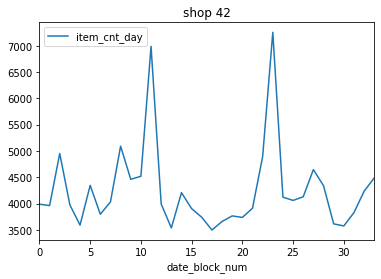

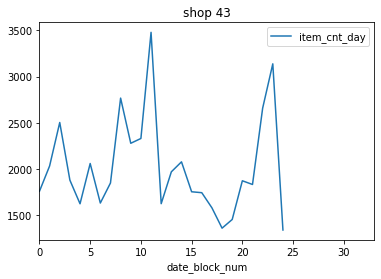

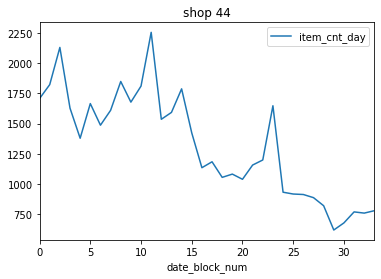

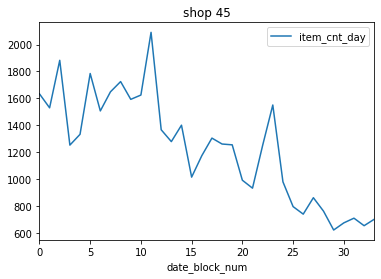

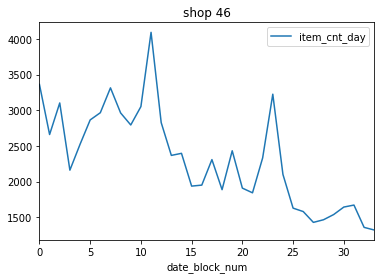

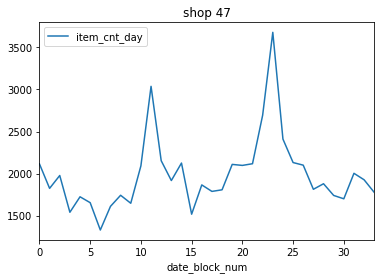

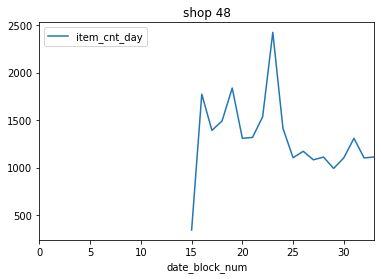

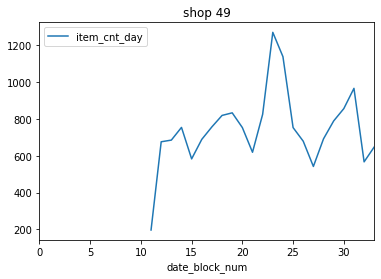

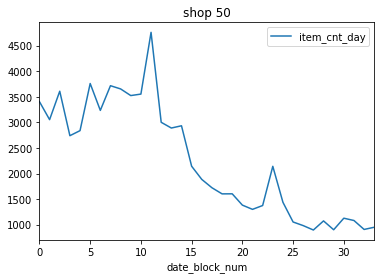

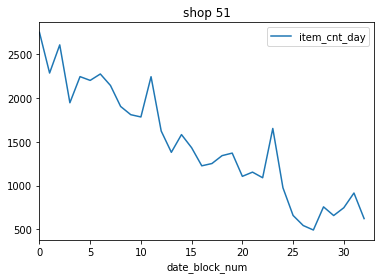

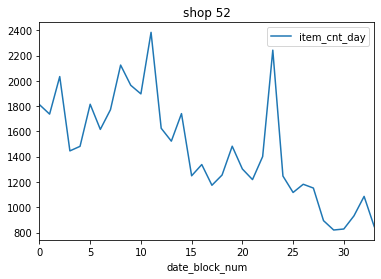

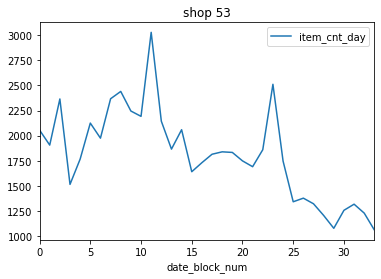

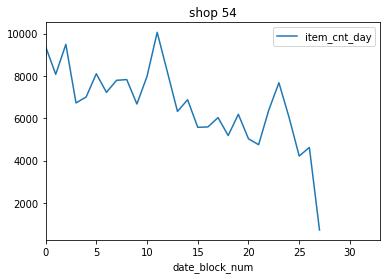

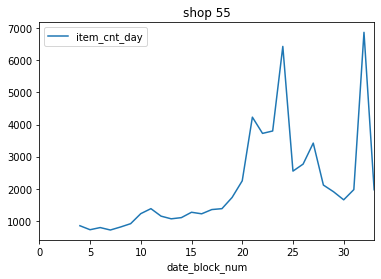

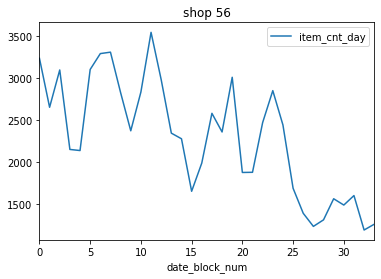

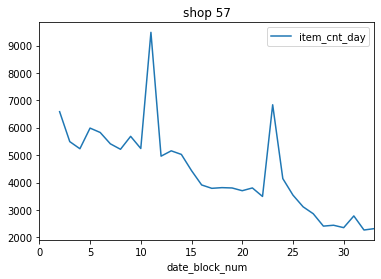

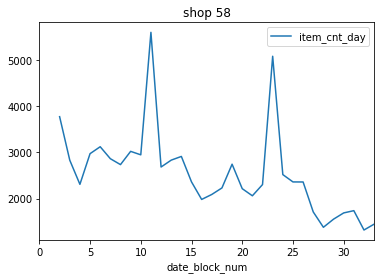

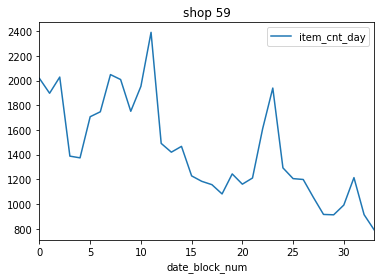

In [3]:
Monthly_sale_shop = train.groupby(["date_block_num","shop_id"],as_index=False)["item_cnt_day"].sum()
MaxSpan = Monthly_sale_shop["date_block_num"].max()
for i in range(len(train["shop_id"])):
    Monthly_sale_shop[Monthly_sale_shop["shop_id"] == i].plot(x="date_block_num",y="item_cnt_day",xlim=[0, MaxSpan],
                                                              title="shop {0}".format(i))

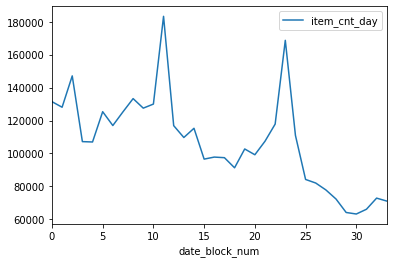

In [4]:
Monthly_sale_total = train.groupby(["date_block_num"],as_index=False)["item_cnt_day"].sum()
Monthly_sale_total.plot(x="date_block_num",y="item_cnt_day")

/Users/QUAN/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  after removing the cwd from sys.path.


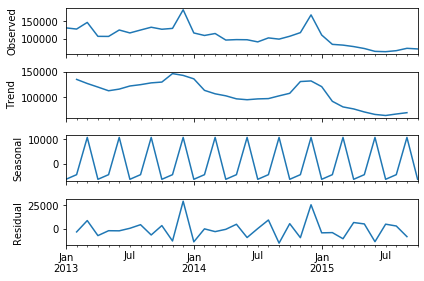

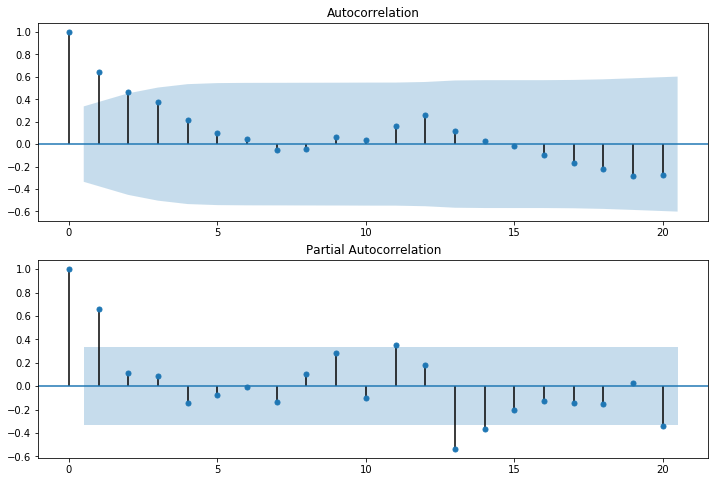

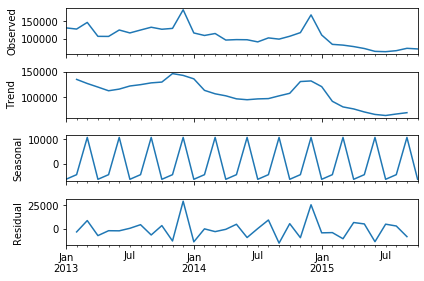

In [5]:
import statsmodels.api as sm

### The index should be given in Datetime format to use seasonal_decompose
Monthly_sale_total["item_cnt_day"].index = pd.DatetimeIndex(freq="m",start='2013-1',periods=len(Monthly_sale_total))

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Monthly_sale_total["item_cnt_day"], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Monthly_sale_total["item_cnt_day"], lags=20, ax=ax2)

res = sm.tsa.seasonal_decompose(Monthly_sale_total["item_cnt_day"], freq=3)
res.plot()

In [7]:
ModData = Monthly_sale_total - Monthly_sale_total.shift(periods=12)
ModData = ModData.dropna()
#test_stationarity(ModData["item_cnt_day"])

/Users/QUAN/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  after removing the cwd from sys.path.
/Users/QUAN/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


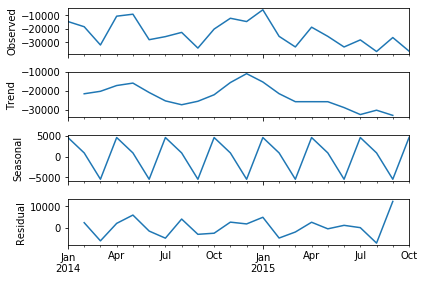

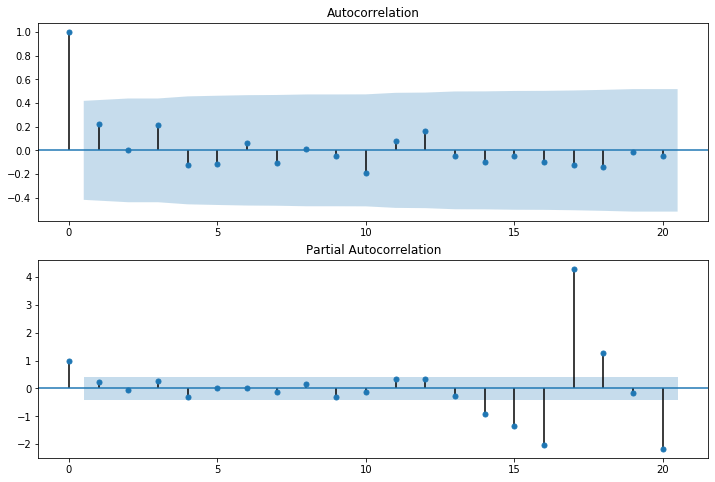

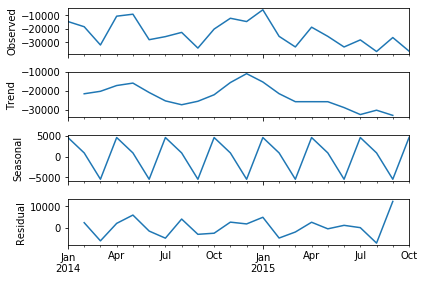

In [8]:
import statsmodels.api as sm

### The index should be given in Datetime format to use seasonal_decompose
ModData.index = pd.DatetimeIndex(freq="m",start='2014-1',periods=len(ModData))

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ModData["item_cnt_day"], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ModData["item_cnt_day"], lags=20, ax=ax2)

res = sm.tsa.seasonal_decompose(ModData["item_cnt_day"], freq=3)
res.plot()

In [9]:

res = sm.tsa.arma_order_select_ic(ModData["item_cnt_day"], ic='aic', trend='nc')
res

/Users/QUAN/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


{'aic':             0           1           2
 0         NaN  492.856767  491.436256
 1  476.808974  472.997112  474.438950
 2  476.798618  475.469579  474.218838
 3  473.530370  473.442550  474.878219
 4  475.006058  475.433981  474.995392, 'aic_min_order': (1, 1)}

In [10]:
ModData.index = pd.DatetimeIndex(freq="m",start='2014-1',periods=len(ModData))
ARMA_1_1 = sm.tsa.ARMA(ModData["item_cnt_day"], (1,1)).fit()
print(ARMA_1_1.summary())

                              ARMA Model Results                              
Dep. Variable:           item_cnt_day   No. Observations:                   22
Model:                     ARMA(1, 1)   Log Likelihood                -229.972
Method:                       css-mle   S.D. of innovations           7990.418
Date:                Sat, 25 Apr 2020   AIC                            467.944
Time:                        20:43:16   BIC                            472.308
Sample:                    01-31-2014   HQIC                           468.972
                         - 10-31-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.356e+04   2270.726    -10.375      0.000    -2.8e+04   -1.91e+04
ar.L1.item_cnt_day    -0.4972      0.239     -2.084      0.051      -0.965      -0.030
ma.L1.item_cnt_day  

/Users/QUAN/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """Entry point for launching an IPython kernel.
/Users/QUAN/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


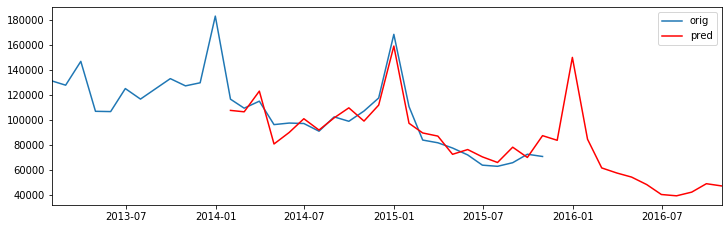

In [11]:

pred = ARMA_1_1.predict('2014-1-31', '2016-10-31')
 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
ax.set_xlim([datetime.date(2013, 1, 31), datetime.date(2016, 10, 31)])
Shifted = Monthly_sale_total["item_cnt_day"].copy()
Shifted.index = pd.date_range('2014-01-01', periods = len(Shifted), freq = 'M')
ax.plot(Monthly_sale_total["item_cnt_day"],label="orig")
ax.plot(pred+Shifted, "r",label="pred")
plt.legend()